In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import numpy as np
import os
from glob import glob
import functions as f
#import climpredNEW.climpred 
#from climpredNEW.climpred.options import OPTIONS
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import itertools
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import pandas as pd
import math
from scipy.stats import percentileofscore as pos
from datetime import datetime
import datetime as dt





2024-02-09 06:55:57.039278: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-09 06:55:59.622556: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-09 06:56:17.860421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook imp

In [2]:
#Set script parameters
CONUS_mask = f.load_CONUS_mask() #Mask of CONUS which serves as our bounding box. Can later change this to a larger file but then we would have to edit the data from the previous scripts. 

#Unet final experiment name (week 5)
experiment_name='EX26_RZSM'

AttributeError: module 'functions' has no attribute 'load_CONUS_mask'

# Data

In [ ]:
#Open observation files
obs_percentile_full = xr.open_mfdataset('Data/GLEAM/RZSM_percentile_reformat/*.nc4',combine='nested',concat_dim=['S']).sel(L=[0,6,13,20,27,34]).astype(np.float16).load()
obs_anomaly_SubX_format = xr.open_mfdataset('Data/GLEAM/reformat_to_reforecast_shape/RZSM_weighted/*.nc4').sel(L=[0,6,13,20,27,34]).astype(np.float32).load()

#Convert back to anomaly
max_RZSM_OBS, min_RZSM_OBS = f.load_observation_min_max_RZSM()
obs_anomaly_SubX_format = f.reverse_min_max_scaling(obs_anomaly_SubX_format,max_RZSM_OBS,min_RZSM_OBS)

obs_anomaly = xr.open_dataset('Data/GLEAM/RZSM_anomaly.nc')


#######################################   Reforecast baseline files   ###########################################################################
baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/RZSM*.nc'))
baseline_percentile_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/percentiles_baseline/RZSM_percentiles_2*.nc'))
baseline_percentile_MEM_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/percentiles_baseline/RZSM_percentiles_MEM_2*.nc'))

baseline_percentile = xr.open_mfdataset(baseline_percentile_file_list,combine='nested',concat_dim=['S']).sel(L=[0,6,13,20,27,34]).astype(np.float32).load()
baseline_percentile_MEM = xr.open_mfdataset(baseline_percentile_MEM_file_list,combine='nested',concat_dim=['S']).sel(L=[0,6,13,20,27,34]).astype(np.float32).load()

#########################################   Prediction (UNET) files   ######################################################################################
unet_anomaly_file_list = sorted(glob(f'predictions/no_julian_dates/{experiment_name}_*.nc'))
unet_percentile_file_list = sorted(glob(f'predictions/UNET/percentiles/{experiment_name}/RZSM_percentiles_2*.nc'))
unet_percentile_MEM_file_list = sorted(glob(f'predictions/UNET/percentiles/{experiment_name}/RZSM_percentiles_MEM_2*.nc'))

unet_percentile = xr.open_mfdataset(unet_percentile_file_list,combine='nested',concat_dim=['S']).sel(L=[0,6,13,20,27,34]).astype(np.float32).load()
unet_percentile_MEM = xr.open_mfdataset(unet_percentile_MEM_file_list,combine='nested',concat_dim=['S']).sel(L=[0,6,13,20,27,34]).astype(np.float32).load()

#Test
# anomaly_file_list=baseline_anomaly_file_list
# percentile_file_list = baseline_percentile_file_list
# percentile_file_list_MEM=baseline_percentile_MEM_file_list
# obs_anomaly=obs_anomaly
# save_dir='Data/GEFSv12_reforecast/soilw_bgrnd/SMVI'
# MEM_or_by_model='MEM'



# Create SMVI on observations

## 7 day running average anomaly is < 21 day running average anomaly for at least 3 weeks. AND at the end of the 3 weeks the RZSM percentile is <= 20th.

In [ ]:
def SMVI_OBSERVATIONS_ONLY(anomaly_file_obs,obs_anomaly_fun,obs_percentile_full_run):
    #test
    # anomaly_file_SubX_format = obs_anomaly_SubX_format
    
    save_dir = 'Data/GLEAM/SMVI'
    os.system(f'mkdir -p {save_dir}')
    
    save_count_name = f'{save_dir}/obs_smvi_count.txt'
    
    smvi_count = []
    for idx,date in enumerate(anomaly_file_obs.S.values):
        # break
        save_name = f'{save_dir}/SMVI_{date}.nc'
        if os.path.exists(save_name):
            pass
        else:
            
            smvi = anomaly_file_obs.sel(S=date).copy(deep=True).load()
            smvi.RZSM[:,:,:,:] = 0
            
            #To save the flash drought occurrence
            fd = smvi.copy(deep=True)
            
            #First get the previous 21 days average from the observation based on the initialization date
            previous_21_days = pd.to_datetime(date) - dt.timedelta(days=21)
            previous_day = pd.to_datetime(date) - dt.timedelta(days=1)

            mean_21_days = obs_anomaly.sel(time=slice(previous_21_days, previous_day)).mean(dim='time').RZSM
            mean_21_days = mean_21_days.rename({'latitude':'Y','longitude':'X'})

            #Now find the first 3 leads and if they are all less than the 21 day mean average, AND the percentile is less than 20th, then FD is occurring. 
            smvi_subset = smvi.copy(deep=True)

            #Now apply the function for if first 3 weeks are less than the previous 21 day average
            #Even though we have multiple models, this is only to make comparisons easier later
            less_than_21_day_average = np.all(anomaly_file_obs.isel(L=[1,2,3],M=0).RZSM.values < mean_21_days.values,axis=(0,1))

            arr = smvi_subset.RZSM[0,3,:,:].values #blank array
            # Replace values where less_than_21_day_average is True with 1 (all 3 must be true)
            arr[less_than_21_day_average] = 1
            #Replace values
            smvi_subset.RZSM[:,3,:,:] = arr

            #Now check percentile values. If True for smvi_subset and if obs_percentile is less than 20th, then FD has begun
            #Only need the first model because all the other models are the same values (just so that it's in SubX format)
            arr_percentile = obs_percentile_full_run.sel(S=date).RZSM_percentile[0,3,:,:].values
            fd_begin = np.where((arr_percentile[:,:] <= 20) & (smvi_subset.RZSM[0,3,:,:].values == 1),1,0)

            #Now continue flash drought if below the 20th percentile
            fd_wk1 = np.where((obs_percentile_full_run.sel(S=date).RZSM_percentile[0,4,:,:].values <= 20) & (fd_begin[:,:] == 1),1,0)
            fd_wk2 = np.where((obs_percentile_full_run.sel(S=date).RZSM_percentile[0,5,:,:].values <= 20) & (fd_wk1[:,:] == 1),1,0)
            np.count_nonzero(fd_wk2)
            #Make sure the flash drought lasts at least 2 weeks
            fd_duration = np.where((fd_begin==1) & (fd_wk1==1) & (fd_wk2==1),1,0)
            np.count_nonzero(fd_duration)
            
            #Now add back to dataset
            fd.RZSM[:,3,:,:] = fd_duration
            fd.RZSM[:,4,:,:] = fd_duration
            fd.RZSM[:,5,:,:] = fd_duration
            
            fd = fd.astype(np.int16)
            
            fd = fd.expand_dims({'S':1}).rename({'RZSM':'smvi'})
            fd.to_netcdf(save_name)
            
            MEM_count = np.count_nonzero(fd.smvi.values)//(fd.M.shape[0]*3)
            print(f'Total FD events:{MEM_count}')
            
            smvi_count.append(MEM_count)
            
    return(smvi_count)


####### RUN FUNCTION ##############################

smvi_count_by_week_obs = SMVI_OBSERVATIONS_ONLY(anomaly_file_obs = obs_anomaly_SubX_format, obs_anomaly_fun=obs_anomaly,
                                               obs_percentile_full_run = obs_percentile_full)

save_smvi_obs_text = f"Data/GLEAM/SMVI/obs_smvi_count.txt"

if os.path.exists(save_smvi_obs_text):
    # Create an empty list to store the lines
    smvi_count_by_week_obs = []

    # Open file in read mode
    with open(save_smvi_obs_text, "r") as file:
        # Read each line and append to the list
        for line in file:
            smvi_count_by_week_obs.append(int(line.strip()))  # strip() removes leading and trailing whitespaces

else:
    with open(save_smvi_obs_text, "w") as file:
        for item in smvi_count_by_week_obs:
            file.write("%s\n" % item)

#Total weeks in flash drought is simply a single model realization. And it has the number of EVENTS because they all last 2 weeks
smvi_count_by_week_obs



In [ ]:
def SMVI_REFORECASTS_ONLY(anomaly_file_list,percentile_file_list,percentile_file_list_MEM,obs_anomaly,save_dir,MEM_or_by_model):
    #test
    # anomaly_file_SubX_format = obs_anomaly_SubX_format
    
    os.system(f'mkdir -p {save_dir}')
    
    #Get S values (init dates)
    init_dates = percentile_file_list.S.values
    
    if MEM_or_by_model == 'MEM':
        save_name_m = 'SMVI_MEM'
        save_smvi_obs_text = f'{save_dir}/smvi_count_MEM.txt'
    else:
        save_name_m = 'SMVI'
        save_smvi_obs_text = f'{save_dir}/smvi_count.txt'

    #Loop through
    smvi_count_by_week_obs = []
    for idx,date in enumerate(init_dates):
        # break
        save_dates = anomaly_file_list[idx].split('_')[-1].split('.')[0]
        save_name = f'{save_dir}/{save_name_m}_{save_dates}.nc'
        
        if os.path.exists(save_name):
            pass
        else:
            # print(f'Working on date {date}')
            anomaly_file_to_open = [i for i in anomaly_file_list if save_dates in i][0]
            
            if MEM_or_by_model == 'MEM':
                percentile_file_to_open = percentile_file_list_MEM.sel(S=date)
            else:
                percentile_file_to_open = percentile_file_list.sel(S=date)
            
            
            #First get the previous 21 days average from the observation based on the initialization date
            previous_21_days = pd.to_datetime(date) - dt.timedelta(days=21)
            previous_day = pd.to_datetime(date) - dt.timedelta(days=1)

            mean_21_days = obs_anomaly.sel(time=slice(previous_21_days, previous_day)).mean(dim='time').RZSM
            mean_21_days = mean_21_days.rename({'latitude':'Y','longitude':'X'})

            #Now find the first 3 leads and if they are all less than the 21 day mean average, AND the percentile is less than 20th, then FD is occurring. 
            anomaly_file = xr.open_dataset(anomaly_file_to_open).sel(L=[0,6,13,20,27,34])
            
            if MEM_or_by_model == 'MEM':
                anomaly_file = anomaly_file.mean(dim='M')
            
            smvi = anomaly_file.copy(deep=True)
            fd = smvi.copy(deep=True)
            
            if MEM_or_by_model == 'MEM':
                smvi.RZSM[:,:,:,:] = 0
                smvi = smvi.load()
            else:
                smvi.RZSM[:,:,:,:,:] = 0
                smvi = smvi.load()
            
            #Now apply the function for if first 3 weeks are less than the previous 21 day average
            #Even though we have multiple models, this is only to make comparisons easier later
            if MEM_or_by_model == 'MEM':
                less_than_21_day_average = np.all(anomaly_file.isel(L=[1,2,3]).RZSM.values < mean_21_days.values,axis=(0,1))
            else:
                less_than_21_day_average = np.zeros(shape=(anomaly_file.M.shape[0], mean_21_days.values.shape[0],mean_21_days.values.shape[1]))
                
                for model in range(anomaly_file.M.shape[0]):
                    less_than_21_day_average[model,:,:] = np.all(anomaly_file.isel(L=[1,2,3],M=model).RZSM.values < mean_21_days.values,axis=(0,1))

                #Replace 1's with True
                less_than_21_day_average = less_than_21_day_average==1
                
            if MEM_or_by_model == 'MEM':
                arr = smvi.RZSM[0,3,:,:].values
            else:
                arr = smvi.RZSM[0,:,3,:,:].values
            np.count_nonzero(arr)
            
            # Replace values where less_than_21_day_average is True with 1
            arr[less_than_21_day_average] = 1
            np.count_nonzero(arr)
            
            #Replace values
            if MEM_or_by_model == 'MEM':
                smvi.RZSM[0,3,:,:] = arr
            else:
                smvi.RZSM[0,:,3,:,:] = arr
            np.count_nonzero(arr)
            
            #Check some values
            # anomaly_file.RZSM[0,:3,1,0].values
            # mean_21_days[1,0].values
            # less_than_21_day_average[1,0]
            # smvi.RZSM[0,2,1,0].values
            
            
            #Now check percentile values. If True for smvi and if percentile is less than 20th, then FD has begun
            if MEM_or_by_model == 'MEM':
                arr_percentile = percentile_file_to_open.RZSM[:,:,:].values
                arr_percentile.shape
                fd_begin = np.where((arr_percentile[3,:,:] <= 20) & (smvi.RZSM[0,3,:,:].values == 1),1,0)
                fd_begin.shape
                np.count_nonzero(fd_begin)
                #Now continue flash drought if below the 20th percentile
                fd_wk1 = np.where((arr_percentile[4,:,:] <= 20) & (fd_begin[:,:] == 1),1,0)
                fd_wk2 = np.where((arr_percentile[5,:,:] <= 20) & (fd_wk1[:,:] == 1),1,0)
                fd_duration = np.where((fd_begin==1) & (fd_wk1==1) & (fd_wk2==1),1,0)
                np.count_nonzero(fd_duration)
                #Add back to dataset


            else:
                fd_total = np.zeros(shape=(percentile_file_to_open.M.shape[0], mean_21_days.values.shape[0],mean_21_days.values.shape[1]))
                fd_total.shape #(11, 48, 96)
                for model in range(percentile_file_to_open.M.shape[0]):
                    arr_percentile = percentile_file_to_open.RZSM[model,:,:,:].values
                    arr_percentile.shape #(6, 48, 96)
                    fd_begin = np.where((arr_percentile[3,:,:] <= 20) & (smvi.RZSM[0,model,3,:,:].values == 1),1,0)
                    fd_begin.shape
                    np.count_nonzero(fd_begin)
                    #Now continue flash drought if below the 20th percentile
                    fd_wk1 = np.where((arr_percentile[4,:,:] <= 20) & (fd_begin[:,:] == 1),1,0)
                    fd_wk2 = np.where((arr_percentile[5,:,:] <= 20) & (fd_wk1[:,:] == 1),1,0)
                    fd_duration = np.where((fd_begin==1) & (fd_wk1==1) & (fd_wk2==1),1,0)
                    np.count_nonzero(fd_duration)
                    #Add back to dataset
                    fd_total[model,:,:] = fd_duration


            #Now add back to dataset
            if MEM_or_by_model == 'MEM':
                fd.RZSM[0,3,:,:] = fd_duration
                fd.RZSM[0,4,:,:] = fd_duration
                fd.RZSM[0,5,:,:] = fd_duration
            else:
                fd.RZSM[0,:,3,:,:] = fd_duration
                fd.RZSM[0,:,4,:,:] = fd_duration
                fd.RZSM[0,:,5,:,:] = fd_duration
            
            fd = fd.astype(np.int16).rename({'RZSM':'smvi'})
            fd.to_netcdf(save_name)
            
            if MEM_or_by_model == 'MEM':
                smvi_count = np.count_nonzero(fd.smvi.values)//3
                print(f'Total FD events of all MEM: {smvi_count}')
                smvi_count_by_week_obs.append(smvi_count)
            else:
                smvi_count = np.count_nonzero(fd.smvi.values)//(3*11)
                print(f'Total FD events averaged across models: {smvi_count}')
                smvi_count_by_week_obs.append(smvi_count)

    if os.path.exists(save_smvi_obs_text):
        # Create an empty list to store the lines
        smvi_count_by_week_obs = []

        # Open file in read mode
        with open(save_smvi_obs_text, "r") as file:
            # Read each line and append to the list
            for line in file:
                smvi_count_by_week_obs.append(int(line.strip()))  # strip() removes leading and trailing whitespaces
    else:
        with open(save_smvi_obs_text, "w") as file:
            for item in smvi_count_by_week_obs:
                file.write("%s\n" % item)
                
    return(smvi_count_by_week_obs)



In [ ]:
#UNET prediction reforecast data
base_smvi_count_MEM =SMVI_REFORECASTS_ONLY(anomaly_file_list=unet_anomaly_file_list,
                      percentile_file_list = baseline_percentile,
                      percentile_file_list_MEM=baseline_percentile_MEM,
                      obs_anomaly=obs_anomaly,
                      save_dir='Data/GEFSv12_reforecast/soilw_bgrnd/SMVI',
                      MEM_or_by_model='MEM')

#UNET prediction reforecast data
base_smvi_count = SMVI_REFORECASTS_ONLY(anomaly_file_list=unet_anomaly_file_list,
                      percentile_file_list = baseline_percentile,
                      percentile_file_list_MEM=baseline_percentile_MEM,
                      obs_anomaly=obs_anomaly,
                      save_dir='Data/GEFSv12_reforecast/soilw_bgrnd/SMVI',
                      MEM_or_by_model='model_realization')



In [ ]:
#Baseline reforecast data
unet_smvi_count_MEM = SMVI_REFORECASTS_ONLY(anomaly_file_list=baseline_anomaly_file_list,
                      percentile_file_list = unet_percentile,
                      percentile_file_list_MEM=unet_percentile_MEM,
                      obs_anomaly=obs_anomaly,
                      save_dir=f'predictions/UNET/SMVI/{experiment_name}',
                      MEM_or_by_model='MEM')

#Baseline reforecast data
unet_smpvi_count = SMVI_REFORECASTS_ONLY(anomaly_file_list=baseline_anomaly_file_list,
                      percentile_file_list = unet_percentile,
                      percentile_file_list_MEM=unet_percentile_MEM,
                      obs_anomaly=obs_anomaly,
                      save_dir=f'predictions/UNET/SMVI/{experiment_name}',
                      MEM_or_by_model='model_realization')

In [ ]:
############### FIRST LOAD ALL THE DATA, THEY ARE SMALLER FILES ####################################################################

#Do not need to grab L=0, it cannot be used for analysis

#Open observation files
obs_smvi = xr.open_mfdataset('Data/GLEAM/SMVI/SMVI*.nc',combine='nested',concat_dim=['S']).sel(L=[6,13,20,27,34]).load()

#Reforecast baseline files
baseline_reforecast_smvi = xr.open_mfdataset('Data/GEFSv12_reforecast/soilw_bgrnd/SMVI/SMVI_2*.nc',combine='nested',concat_dim=['S']).sel(L=[6,13,20,27,34]).load()
baseline_reforecast_smvi_MEM = xr.open_mfdataset('Data/GEFSv12_reforecast/soilw_bgrnd/SMVI/SMVI_MEM_2*.nc',combine='nested',concat_dim=['S']).sel(L=[6,13,20,27,34]).load()

#Prediction (UNET) files
unet_prediction_SMVI = xr.open_mfdataset(f'predictions/UNET/SMVI/{experiment_name}/SMVI_2*.nc',combine='nested',concat_dim=['S']).sel(L=[6,13,20,27,34]).load()
unet_prediction_SMVI_MEM = xr.open_mfdataset(f'predictions/UNET/SMVI/{experiment_name}/SMVI_MEM_2*.nc',combine='nested',concat_dim=['S']).sel(L=[6,13,20,27,34]).load()


#Test
# anomaly_file_list=baseline_anomaly_file_list
# percentile_file_list = baseline_percentile_file_list
# percentile_file_list_MEM=baseline_percentile_MEM_file_list
# obs_anomaly=obs_anomaly
# save_dir='Data/GEFSv12_reforecast/soilw_bgrnd/SMVI'
# MEM_or_by_model='MEM'

CONUS_mask_arr = CONUS_mask.to_array().values.squeeze().squeeze()

In [ ]:
#CONSTRUCT TRUE POSITIVE, FALSE POSITIVE, FALSE NEGATIVE INFO

def metric_MEM(reforecast_file, observation_file, save_dir):
    os.system(f'mkdir -p {save_dir}')
    #test 
    # reforecast_file = unet_prediction_SMPD_MEM
    # observation_file = obs_smpd
    # save_dir = f'predictions/UNET/SMVI/{experiment_name}'
    
    #Returns the CSI (critical success index metric, true positive rate, and false positive rate)
    csi_out = reforecast_file.isel(S=0).copy(deep=True)
    csi_out.smvi[:,:,:] = 0
    csi_out = csi_out.astype(np.float32)
    
    tpr_out = reforecast_file.isel(S=0).copy(deep=True)
    tpr_out.smvi[:,:,:] = 0
    tpr_out = tpr_out.astype(np.float32)
    
    fpr_out = reforecast_file.isel(S=0).copy(deep=True)
    fpr_out.smvi[:,:,:] = 0
    fpr_out = fpr_out.astype(np.float32)
    
    observation_file = observation_file.mean(dim='M')
    
    #only choose warm season months (March - November)
    reforecast_file_subset = reforecast_file.sel(S=reforecast_file['S.month'].isin([3,4,5,6,7,8,9,10,11]))
    np.count_nonzero(reforecast_file_subset.smvi.values)
    
    observation_file = observation_file.assign_coords(S=reforecast_file.S.values)
    
    observation_file_subset = observation_file.sel(S=observation_file['S.month'].isin([3,4,5,6,7,8,9,10,11]))
    np.count_nonzero(observation_file_subset.smvi.values)

    #True positive
    tp = np.where((observation_file_subset.smvi.values == 1) & (reforecast_file_subset.smvi.values == 1),1,0) 
    np.count_nonzero(tp)
    tp.shape
    np.count_nonzero(np.isnan(tp))

    #False positive
    fp = np.where((observation_file_subset.smvi.values == 0) & (reforecast_file_subset.smvi.values == 1),1,0) 
    np.count_nonzero(fp)
    
    fn = np.where((observation_file_subset.smvi.values == 1) & (reforecast_file_subset.smvi.values == 0),1,0) 
    np.count_nonzero(fn)

    tn = np.where((observation_file_subset.smvi.values == 0) & (reforecast_file_subset.smvi.values == 0),1,0) 
    np.count_nonzero(tn)

    tp_sum = tp.sum(axis=0)
    fp_sum = fp.sum(axis=0)
    fn_sum = fn.sum(axis=0)
    tn_sum = tn.sum(axis=0)
    
    
    TPR = (tp_sum/(tp_sum+fn_sum))*100
    tpr_out.smvi[:,:,:] = TPR
    len(np.unique(tpr_out.smvi.values))
    
    FPR = (fp_sum/(fp_sum+tn_sum))*100
    fpr_out.smvi[:,:,:] = FPR
    len(np.unique(fpr_out.smvi.values))
    
    CSI = (tp_sum/(tp_sum+fp_sum+fn_sum))*100
    csi_out.smvi[:,:,:] = CSI
    len(np.unique(csi_out.smvi.values))

    
    #We could apply numpy where functions, but it's easier just to explicitly loop through data
    for X in range(reforecast_file_subset.X.shape[0]):
        # print(X)
        for Y in range(reforecast_file_subset.Y.shape[0]):
            if CONUS_mask_arr[Y,X] == 1:

                csi_out.smvi[:,Y,X] = np.nan
                fpr_out.smvi[:,Y,X] = np.nan
                tpr_out.smvi[:,Y,X] = np.nan
    
    #Now save the data
    csi_out.to_netcdf(f'{save_dir}/csi_percentage_MEM.nc')
    tpr_out.to_netcdf(f'{save_dir}/tpr_percentage_MEM.nc')
    fpr_out.to_netcdf(f'{save_dir}/fpr_percentage_MEM.nc')
            
                    
                

In [ ]:
# Run the different metrics across CONUS for MEM
metric_MEM(reforecast_file=baseline_reforecast_smvi_MEM, observation_file=obs_smvi, save_dir='Data/GEFSv12_reforecast/soilw_bgrnd/SMVI/metric_values')
metric_MEM(reforecast_file=unet_prediction_SMVI_MEM, observation_file=obs_smvi, save_dir=f'predictions/UNET/SMVI/{experiment_name}/metric_values')

In [ ]:
#CONSTRUCT TRUE POSITIVE, FALSE POSITIVE, FALSE NEGATIVE INFO

def metric_ensemble_realization_probability(reforecast_file, observation_file, save_dir, probability):
    
    #test for 
    # reforecast_file = unet_prediction_SMPD_MEM
    # observation_file = obs_smpd
    # save_dir = f'predictions/UNET/SMVI/{experiment_name}'

    #There are 11 different model realizations, so just assume 10 models for probability sake

    os.system(f'mkdir -p {save_dir}')
    
    #Returns the CSI (critical success index metric, true positive rate, and false positive rate)
    csi_out = reforecast_file.isel(S=0).mean(dim='M').copy(deep=True)
    csi_out.smvi[:,:,:] = 0
    csi_out = csi_out.astype(np.float32)
    
    tpr_out = reforecast_file.isel(S=0).mean(dim='M').copy(deep=True)
    tpr_out.smvi[:,:,:] = 0
    tpr_out = tpr_out.astype(np.float32)
    
    fpr_out = reforecast_file.isel(S=0).mean(dim='M').copy(deep=True)
    fpr_out.smvi[:,:,:] = 0
    fpr_out = fpr_out.astype(np.float32)
        
    #only choose warm season months (March - November)
    reforecast_file_subset = reforecast_file.sel(S=reforecast_file['S.month'].isin([3,4,5,6,7,8,9,10,11]))
    np.count_nonzero(reforecast_file_subset.smvi.values)
    
    observation_file = observation_file.assign_coords(S=reforecast_file.S.values)
    
    observation_file_subset = observation_file.sel(S=observation_file['S.month'].isin([3,4,5,6,7,8,9,10,11]))
    np.count_nonzero(observation_file_subset.smvi.values)
    
    #True positive
    tp = np.where((observation_file_subset.smvi.values == 1) & (reforecast_file_subset.smvi.values == 1),1,0) 
    np.count_nonzero(tp)
    tp.shape
    np.count_nonzero(np.isnan(tp))

    #False positive
    fp = np.where((observation_file_subset.smvi.values == 0) & (reforecast_file_subset.smvi.values == 1),1,0) 
    np.count_nonzero(fp)
    
    fn = np.where((observation_file_subset.smvi.values == 1) & (reforecast_file_subset.smvi.values == 0),1,0) 
    np.count_nonzero(fn)

    tn = np.where((observation_file_subset.smvi.values == 0) & (reforecast_file_subset.smvi.values == 0),1,0) 
    np.count_nonzero(tn)
    
    #Now only sum over the model realization and see if the probability exceeds it
    tp_sum_prob = np.where(tp.sum(axis=1) >= probability*10,1,0).sum(axis=0)
    tp_sum_prob.shape
    fp_sum_prob = np.where(fp.sum(axis=1) >= probability*10,1,0).sum(axis=0)
    fn_sum_prob = np.where(fn.sum(axis=1) >= probability*10,1,0).sum(axis=0)
    tn_sum_prob = np.where(tn.sum(axis=1) >= probability*10,1,0).sum(axis=0)
    
    
    TPR = (tp_sum_prob/(tp_sum_prob+fn_sum_prob))*100
    tpr_out.smvi[:,:,:] = TPR
    len(np.unique(tpr_out.smvi.values))
    
    FPR = (fp_sum_prob/(fp_sum_prob+tn_sum_prob))*100
    fpr_out.smvi[:,:,:] = FPR
    len(np.unique(fpr_out.smvi.values))
    
    CSI = (tp_sum_prob/(tp_sum_prob+fp_sum_prob+fn_sum_prob))*100
    csi_out.smvi[:,:,:] = CSI
    len(np.unique(csi_out.smvi.values))

    
    #We could apply numpy where functions, but it's easier just to explicitly loop through data
    for X in range(reforecast_file_subset.X.shape[0]):
        # print(X)
        for Y in range(reforecast_file_subset.Y.shape[0]):
            if CONUS_mask_arr[Y,X] == 1:

                csi_out.smvi[:,Y,X] = np.nan
                fpr_out.smvi[:,Y,X] = np.nan
                tpr_out.smvi[:,Y,X] = np.nan
    
    #Now save the data
    csi_out.to_netcdf(f'{save_dir}/csi_percentage_probability{probability}.nc')
    tpr_out.to_netcdf(f'{save_dir}/tpr_percentage_probability{probability}.nc')
    fpr_out.to_netcdf(f'{save_dir}/fpr_percentage_probability{probability}.nc')
            
                    
                

In [ ]:
# Run the different metrics across CONUS for MEM
metric_ensemble_realization_probability(reforecast_file=baseline_reforecast_smvi, observation_file=obs_smvi, save_dir='Data/GEFSv12_reforecast/soilw_bgrnd/SMVI/metric_values', probability = 0.5)
metric_ensemble_realization_probability(reforecast_file=unet_prediction_SMVI, observation_file=obs_smvi, save_dir=f'predictions/UNET/SMVI/{experiment_name}/metric_values', probability = 0.5)

# Open SMVI flash drought onset and plot

In [3]:
obs_smvi = xr.open_mfdataset('Data/GLEAM/SMVI/SMVI*.nc').sel(L=[20,27,34]).load()
baseline_smvi = xr.open_mfdataset('Data/GEFSv12_reforecast/soilw_bgrnd/SMVI/SMVI_MEM*.nc').sel(L=[20,27,34]).load()
unet_smvi = xr.open_mfdataset(f'predictions/UNET/SMVI/{experiment_name}/SMVI_MEM*.nc').sel(L=[20,27,34]).load()

In [5]:
#dates
start_ = '2019-08-01'
end_ = '2019-10-30'

#Mask with np.nan for non-CONUS land values
mask_anom = CONUS_mask['NCA-LDAS_mask'][0,:,:].values

In [6]:
obs_anom = obs_smvi.sel(S=slice(start_,end_)).mean(dim='M')
unet_anom = unet_smvi.sel(S=slice(start_,end_))
baseline_anom = baseline_smvi.sel(S=slice(start_,end_))

obs_anom = xr.where(mask_anom ==1, obs_anom,np.nan)
unet_anom = xr.where(mask_anom ==1, unet_anom,np.nan)
baseline_anom = xr.where(mask_anom ==1, baseline_anom,np.nan)

obs_anom = obs_anom.assign_coords({'S':unet_anom.S.values})

unet_anom = xr.where(~np.isnan(obs_anom), unet_anom,np.nan)
baseline_anom = xr.where(~np.isnan(obs_anom), baseline_anom,np.nan)

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'S' ('S',)

In [27]:
def get_min_max_of_files(obs, unet, baseline, date):
    #test 
    # date = '2019-08-07'
    
    min_ = []
    max_ = []

    min_.append(obs.sel(S=date).min().smvi.values)
    min_.append(unet.sel(S=date).min().smvi.values)
    min_.append(baseline.sel(S=date).min().smvi.values)

    max_.append(obs.sel(S=date).max().smvi.values)
    max_.append(unet.sel(S=date).max().smvi.values)
    max_.append(baseline.sel(S=date).max().smvi.values)

    return(min(min_),max(max_))

In [28]:
def return_array(file,lead,date):
    return(file.sel(L=lead,S=date).smvi.values)

In [35]:


   
# cmap = 'coolwarm'
def plot_case_study_rci(obs, unet, baseline, init_date):
    cmap = plt.get_cmap('bwr')    
    
    save_dir = f'Outputs/Case_studies/Southeast_US/SMVI'
    os.system(f'mkdir -p {save_dir}')
        
    fig, axs = plt.subplots(
        nrows = 3, ncols= 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 10))
    axs = axs.flatten()
    
    init_date = pd.to_datetime(init_date)
    date = f'{init_date.year}-{init_date.month:02}-{init_date.day:02}'
    
    min_,max_ = get_min_max_of_files(obs, unet, baseline, date)
    # test_file = mae_rzsm_keys
    # for Subx original data
    
    lon = obs.X.values
    lat = obs.Y.values
    
    axs_start = 0
    for lead in [20,27,34]:
        for data_to_plot,name in zip([obs, unet, baseline], ['GLEAM','UNET','Baseline']):
            # break
            data = return_array(file=data_to_plot,lead=lead, date=date)
    
            # v = np.linspace(min_, max_, 20, endpoint=True)
        
            map = Basemap(projection='cyl', llcrnrlat=25, urcrnrlat=50,
                          llcrnrlon=-128, urcrnrlon=-60, resolution='l')
            x, y = map(*np.meshgrid(lon, lat))
            # Adjust the text coordinates based on the actual data coordinates
        
        
            im = axs[axs_start].contourf(x, y, data, extend='both',
                                  transform=ccrs.PlateCarree(), cmap=cmap)
    
    
            # axs[idx].title.set_text(f'SubX Lead {lead*7}')
            gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                       linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
            gl.xlabels_top = False
            gl.ylabels_right = False
            if lead != 1:
                gl.ylabels_left = False
            gl.xformatter = LongitudeFormatter()
            gl.yformatter = LatitudeFormatter()
            axs[axs_start].coastlines()
            # plt.colorbar(im)
            # axs[idx].set_aspect('auto', adjustable=None)
            axs[axs_start].set_aspect('equal')  # this makes the plots better
            axs[axs_start].set_title(f'{name} Lead {lead}',fontsize=15)
            axs_start+=1
    cbar_ax = fig.add_axes([0.05, -0.05, .9, .04])
    
    # Draw the colorbar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    fig.suptitle(f'Init date: {date}', fontsize=30)
    fig.tight_layout()
    
    plt.savefig(f'{save_dir}/Southeast_SMVI_init{date}.png',bbox_inches='tight')
    plt.show()


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

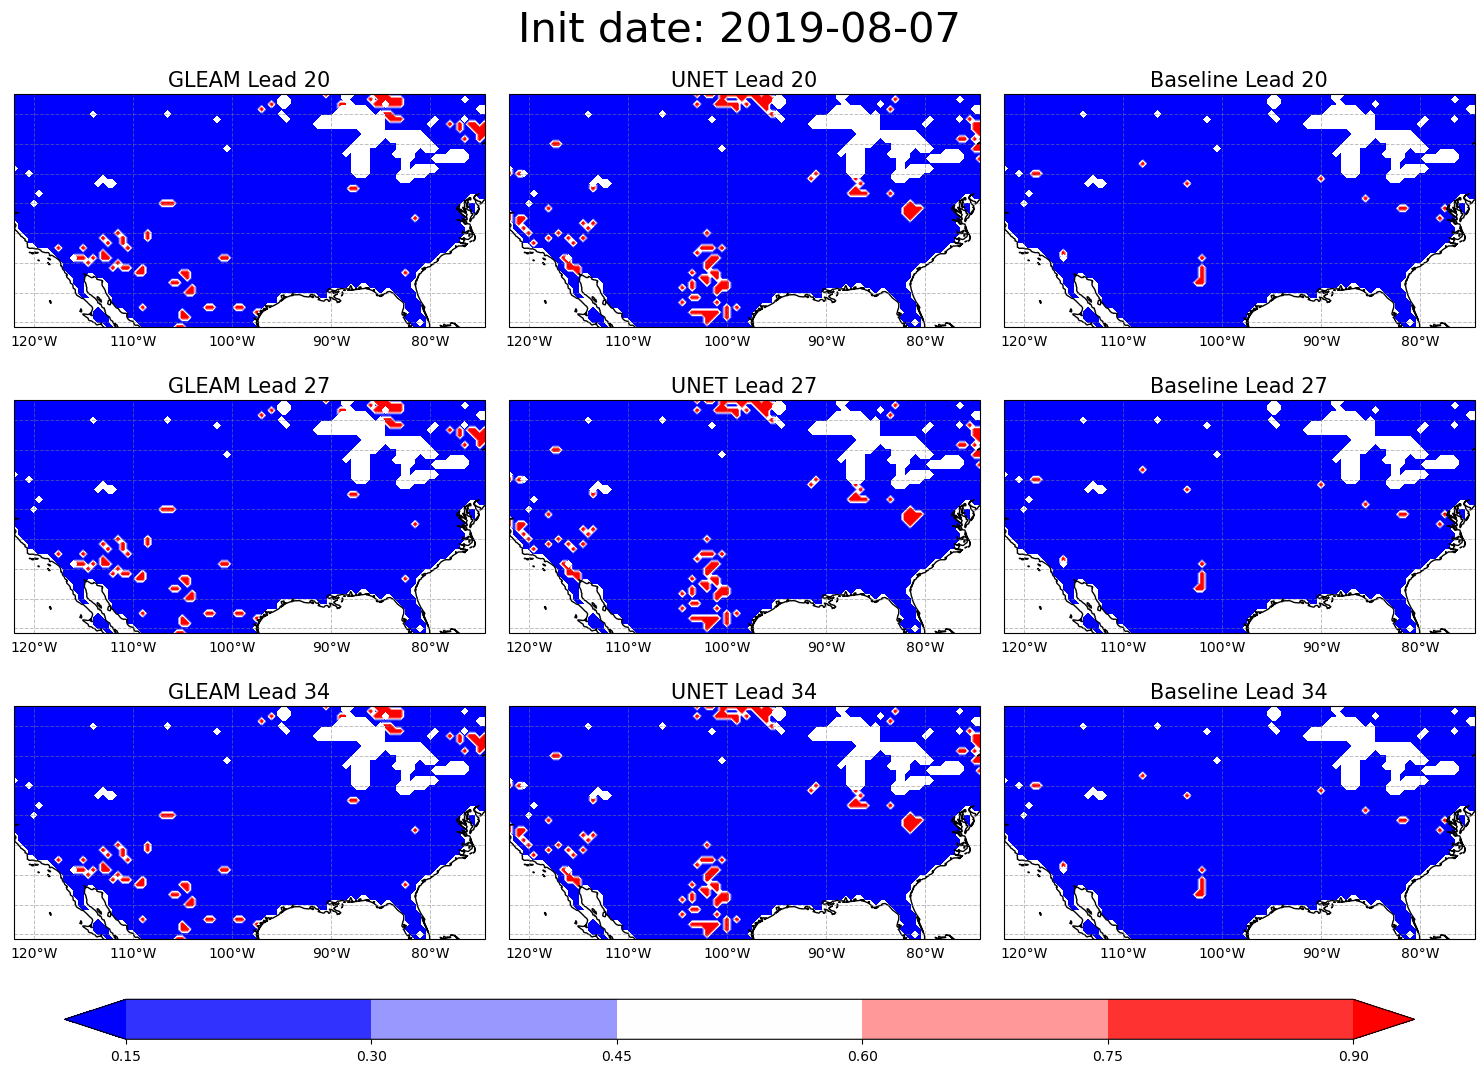

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

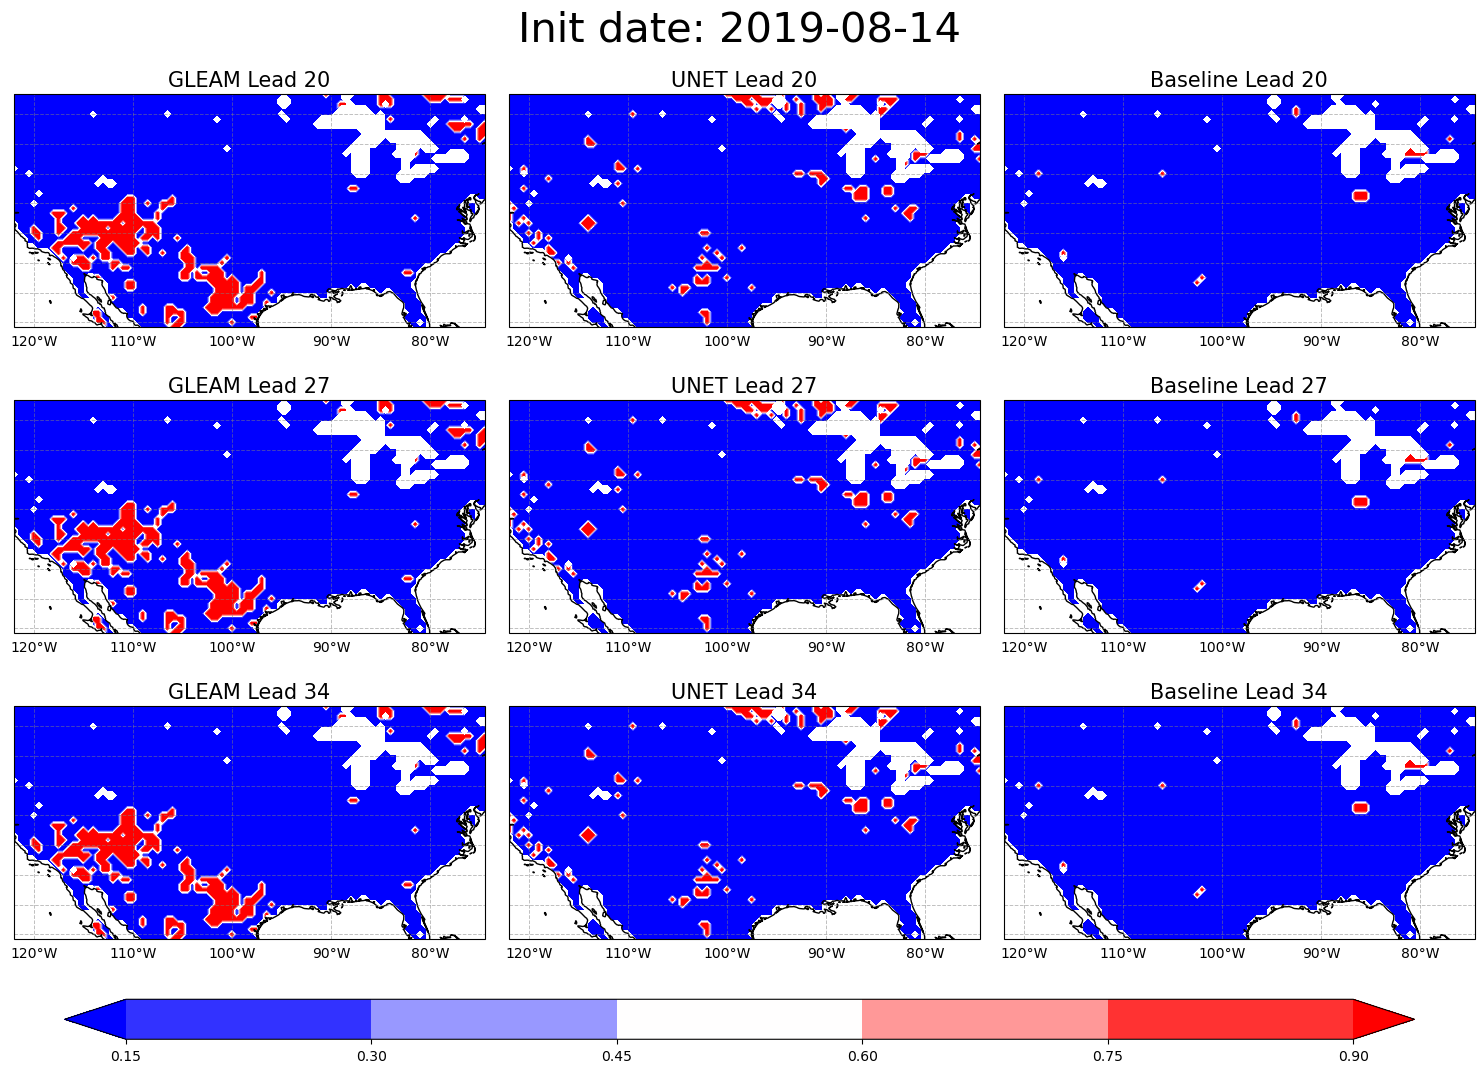

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

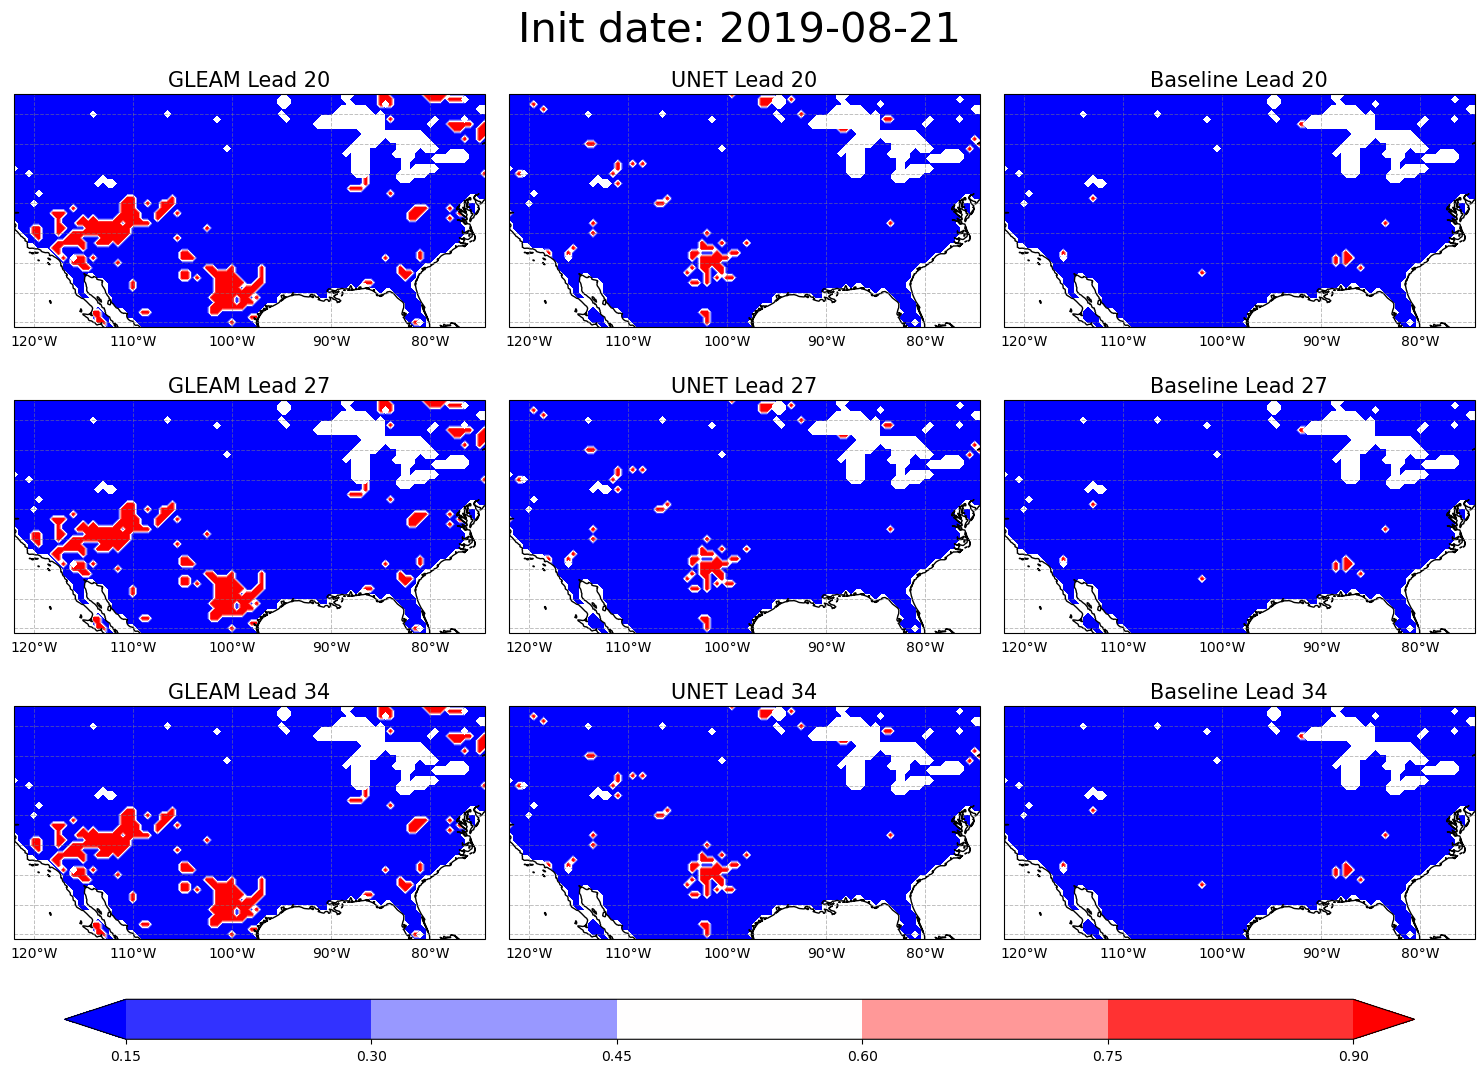

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

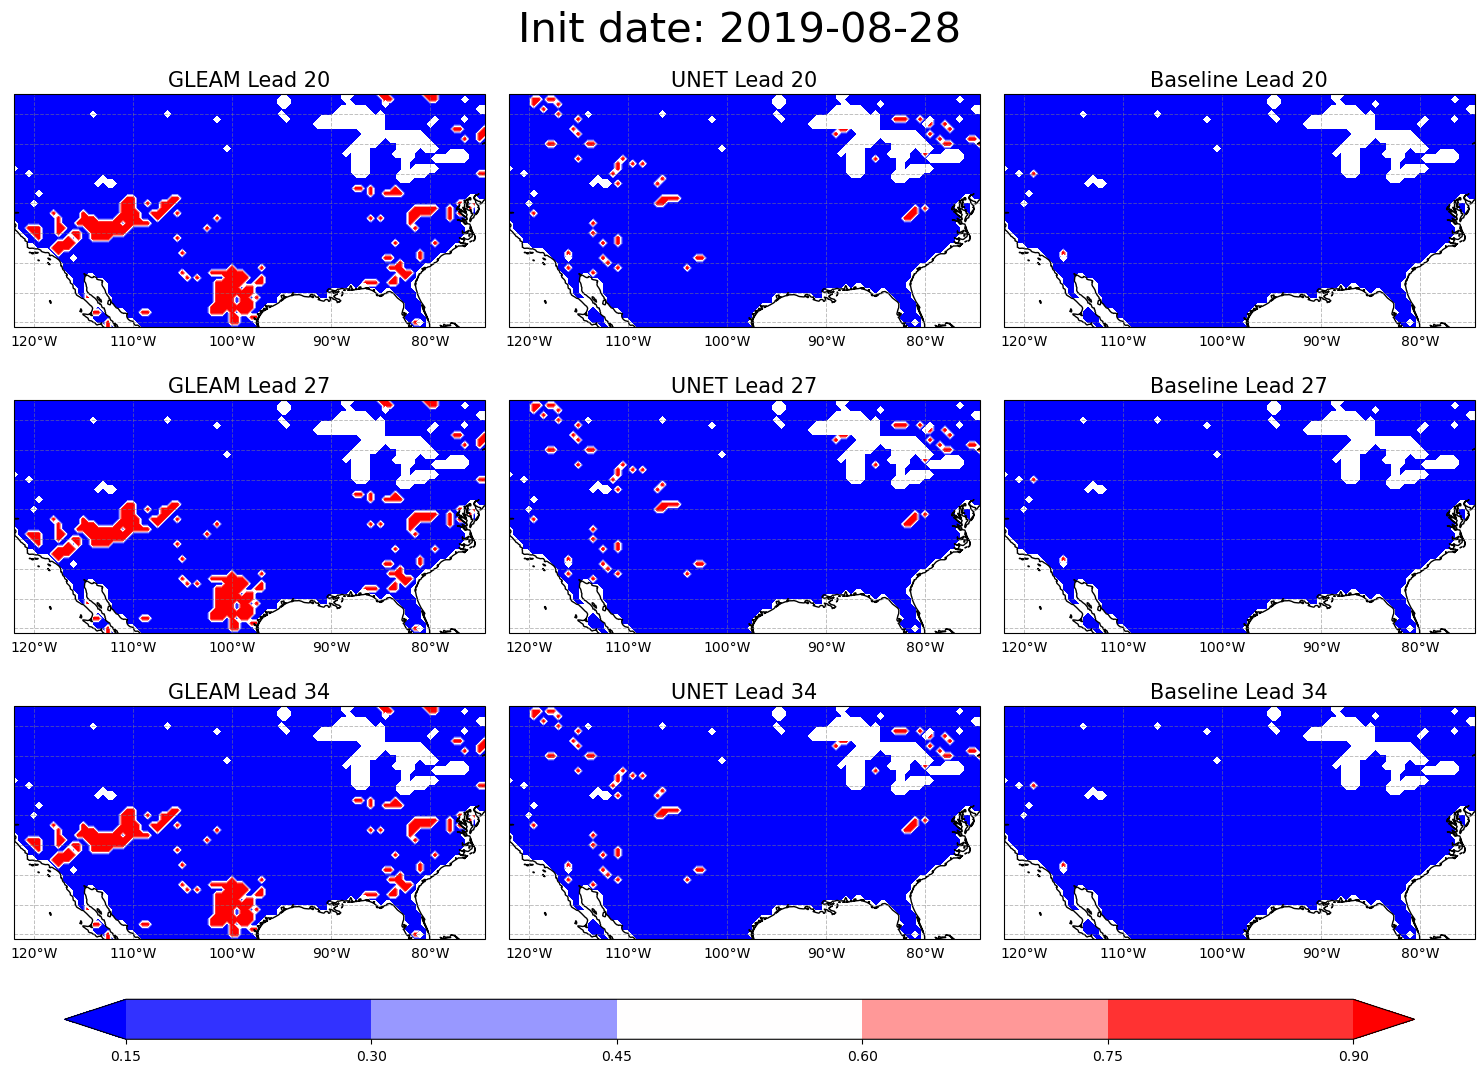

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

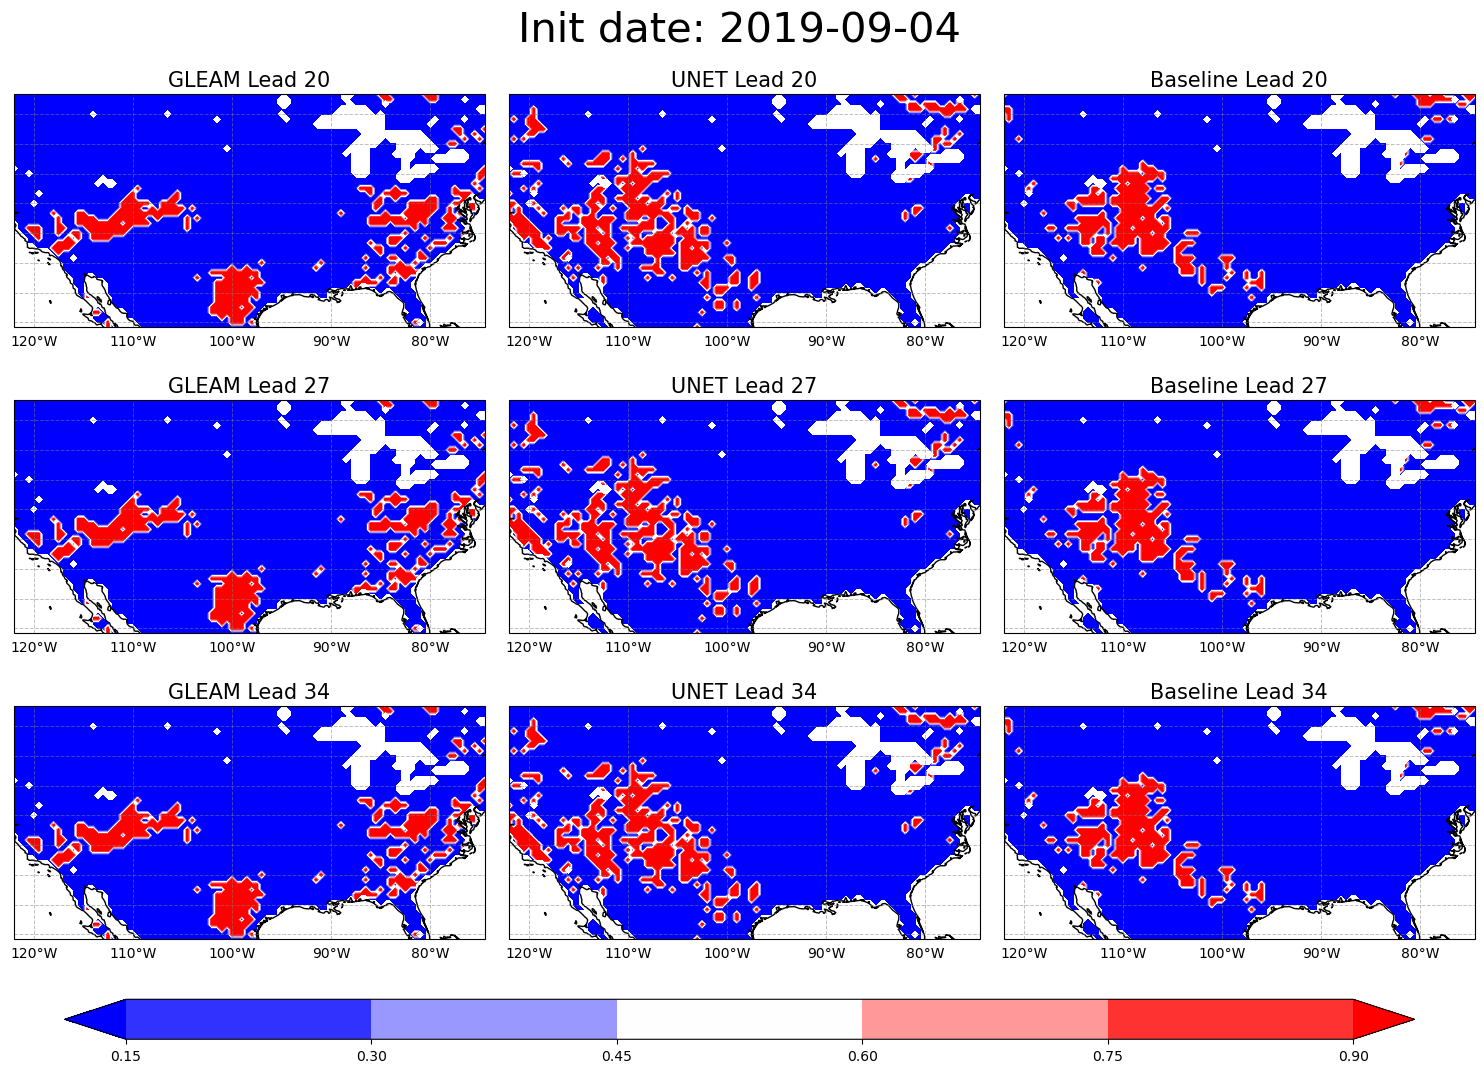

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

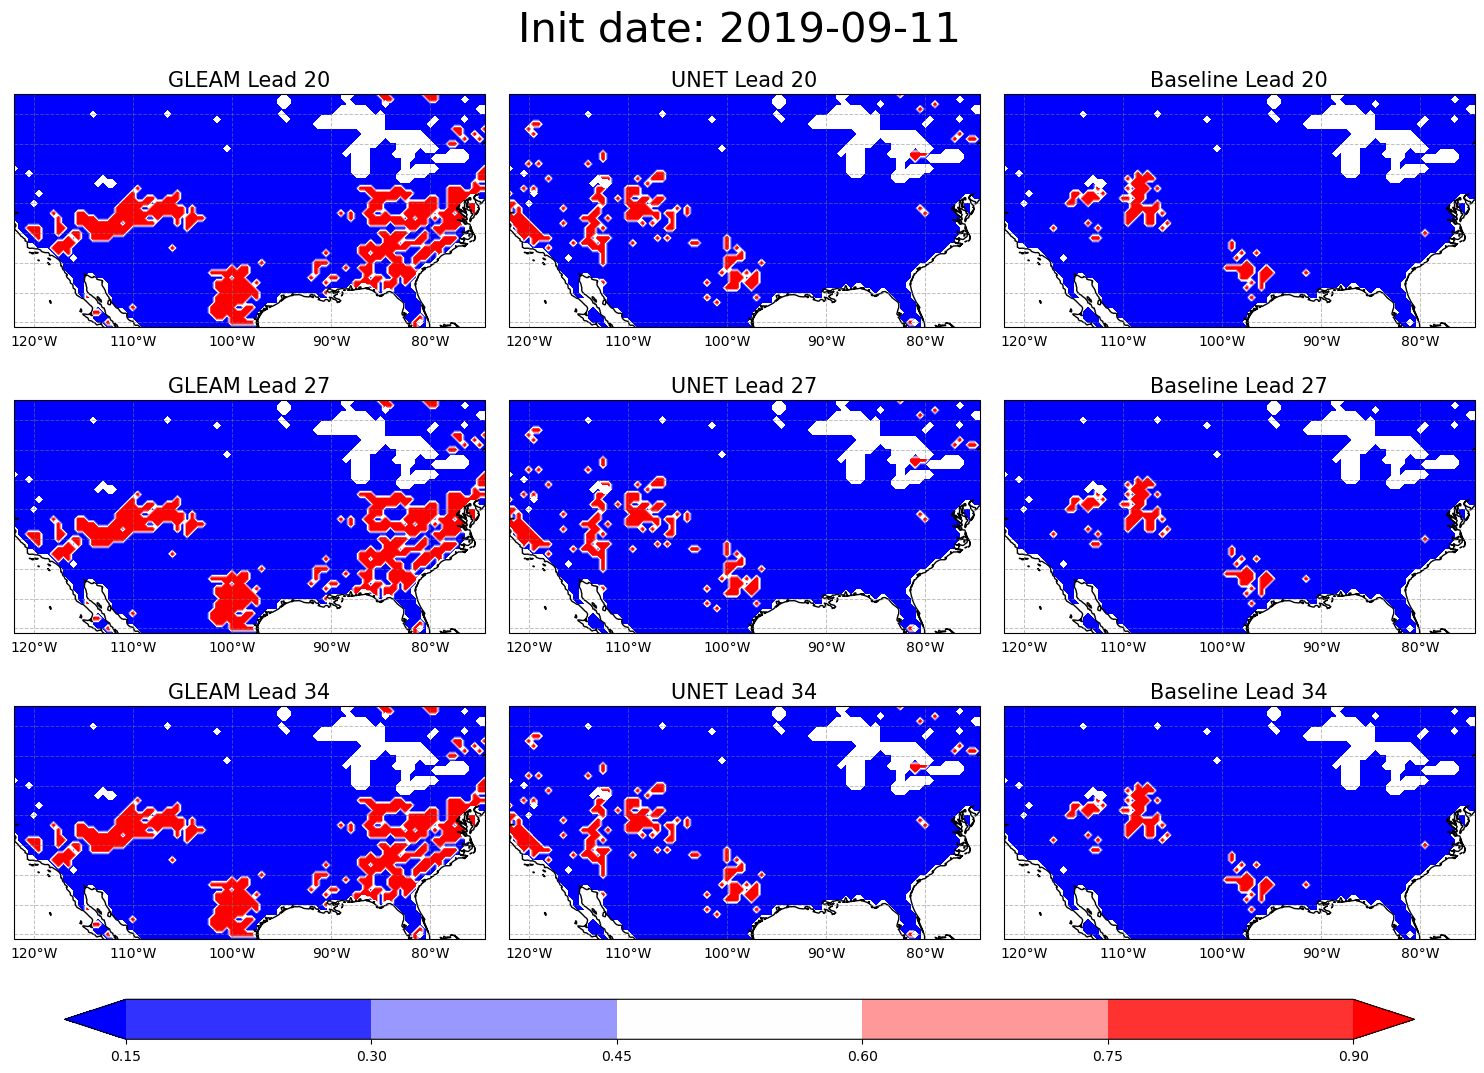

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

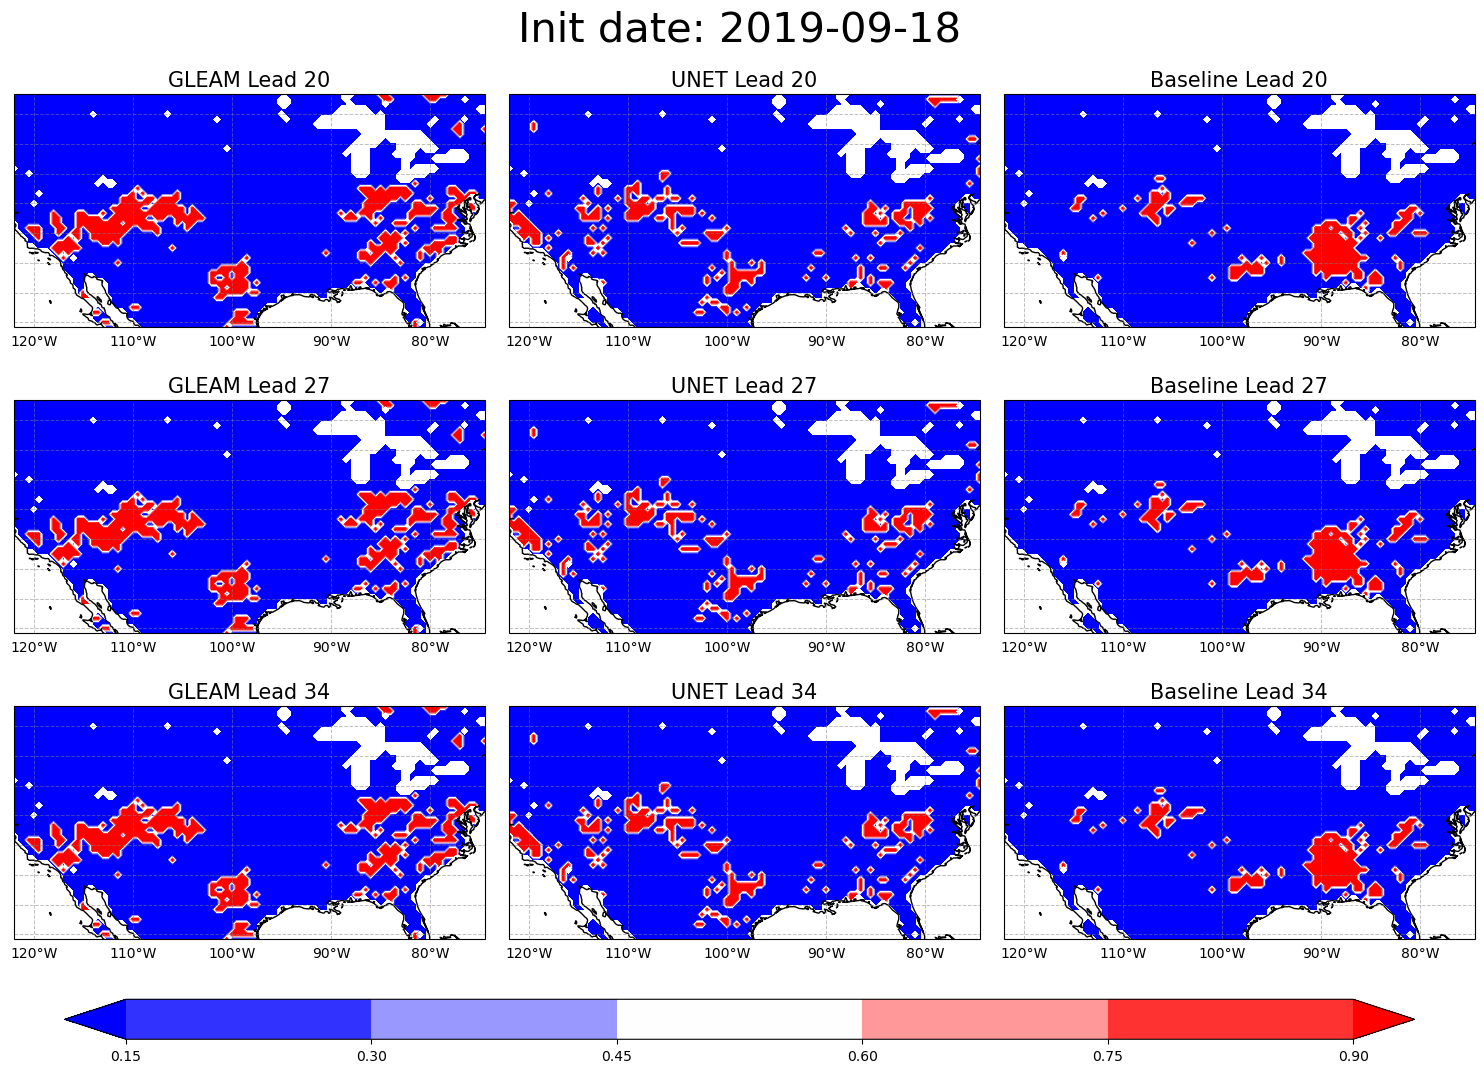

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

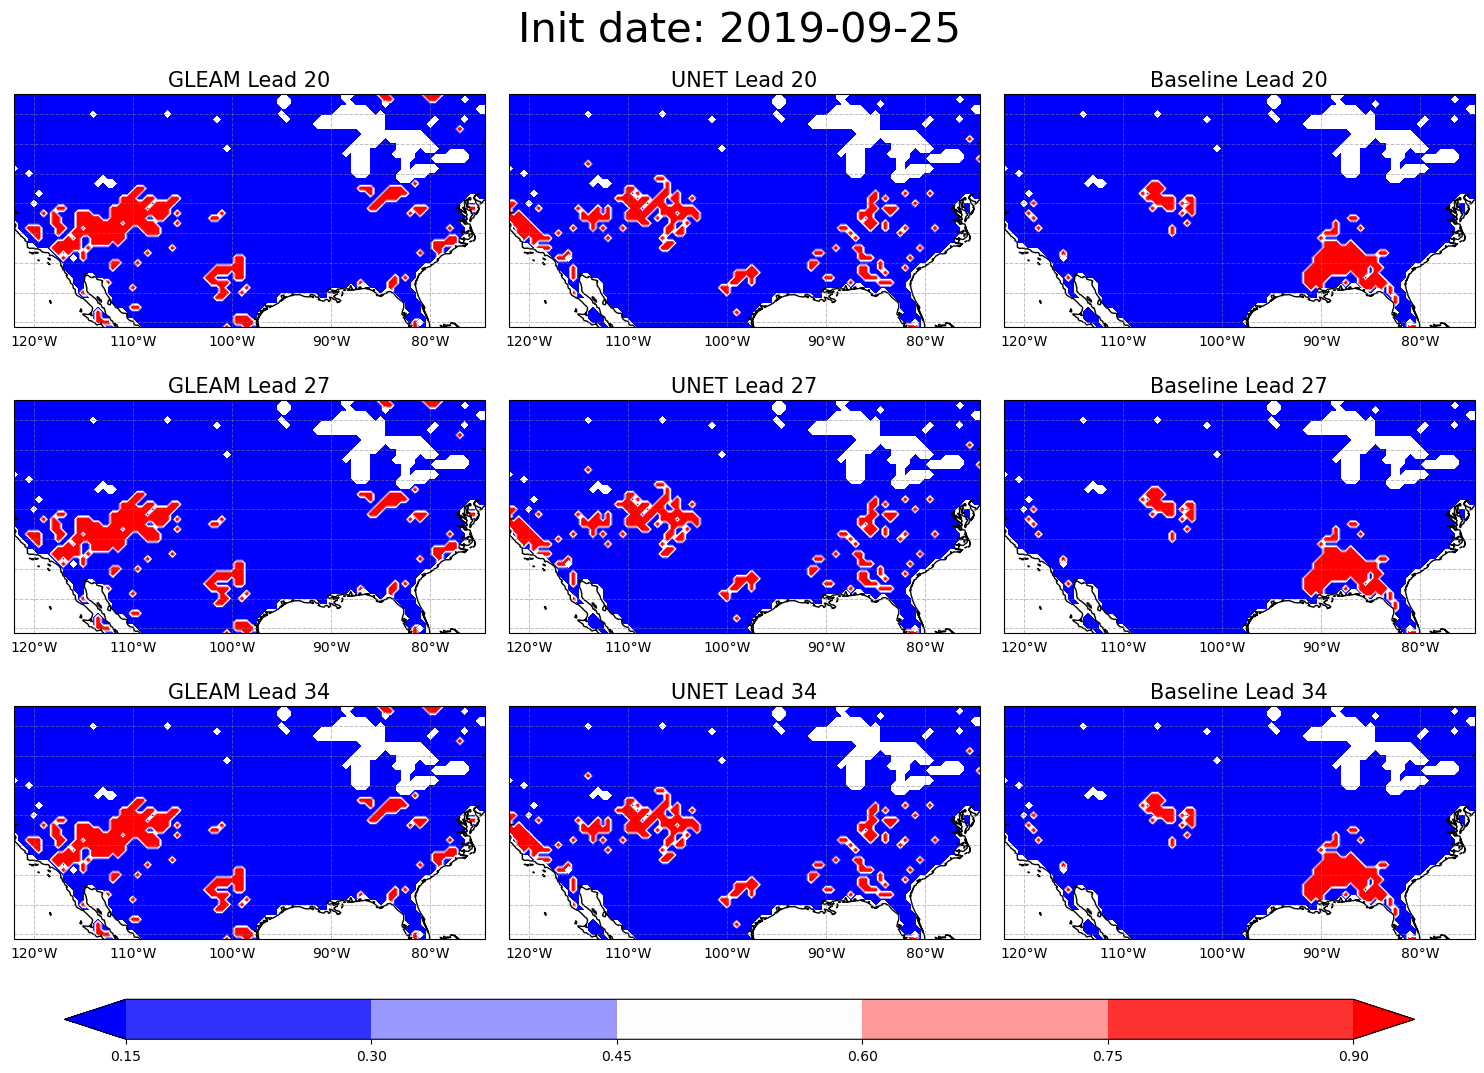

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

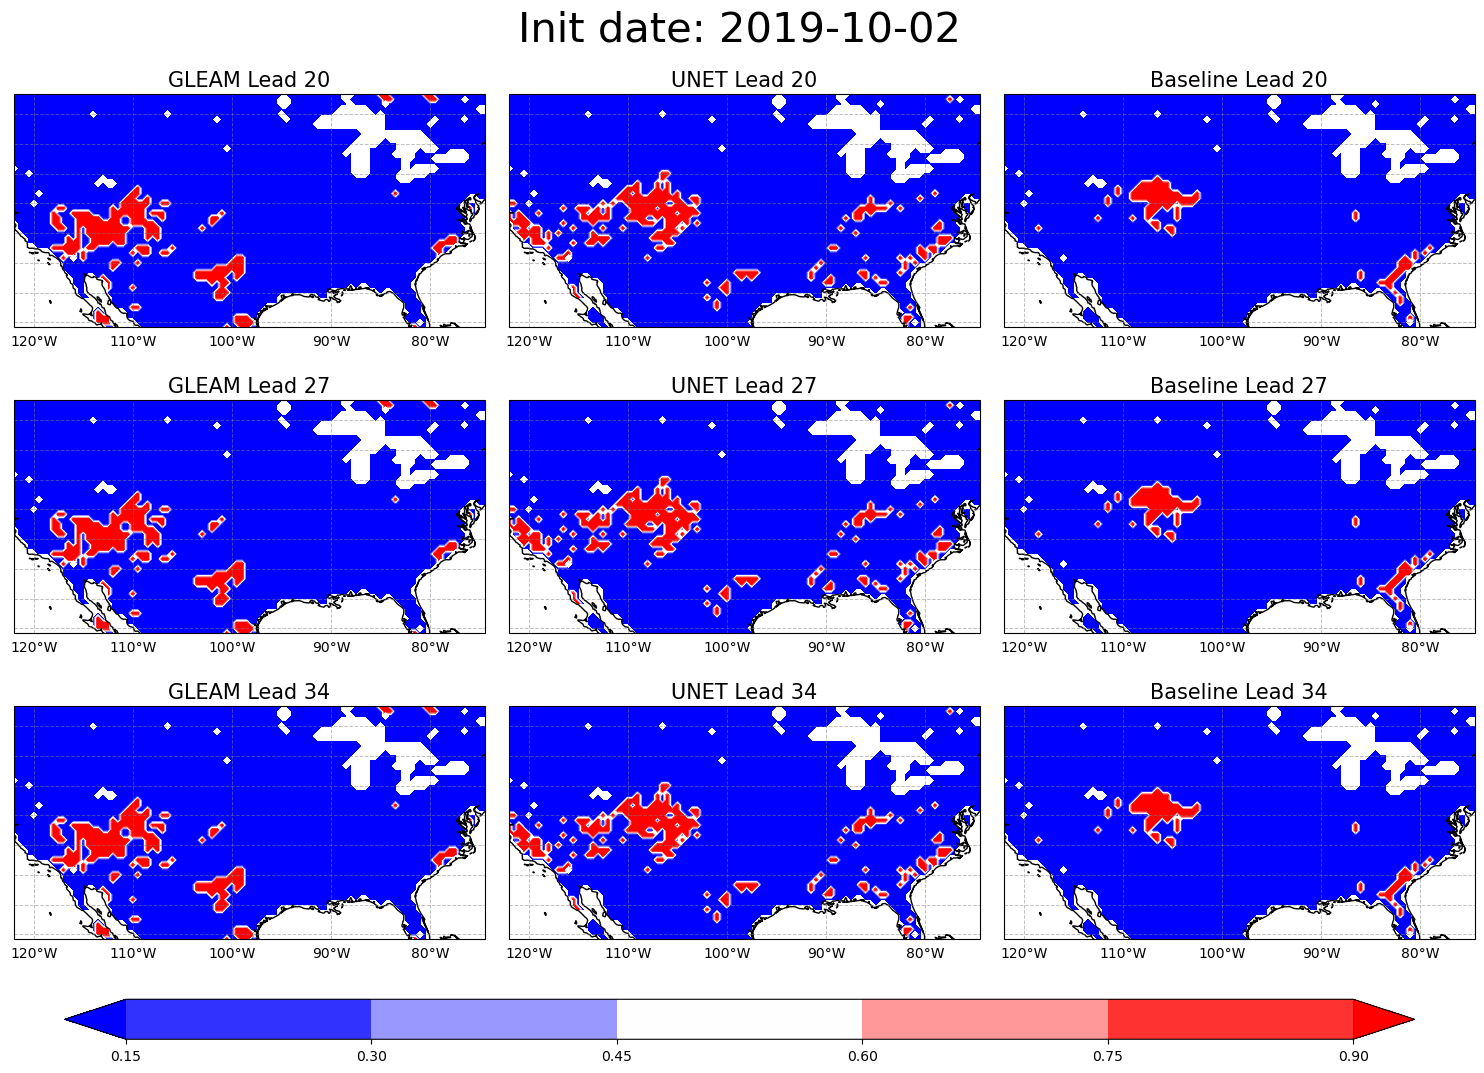

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

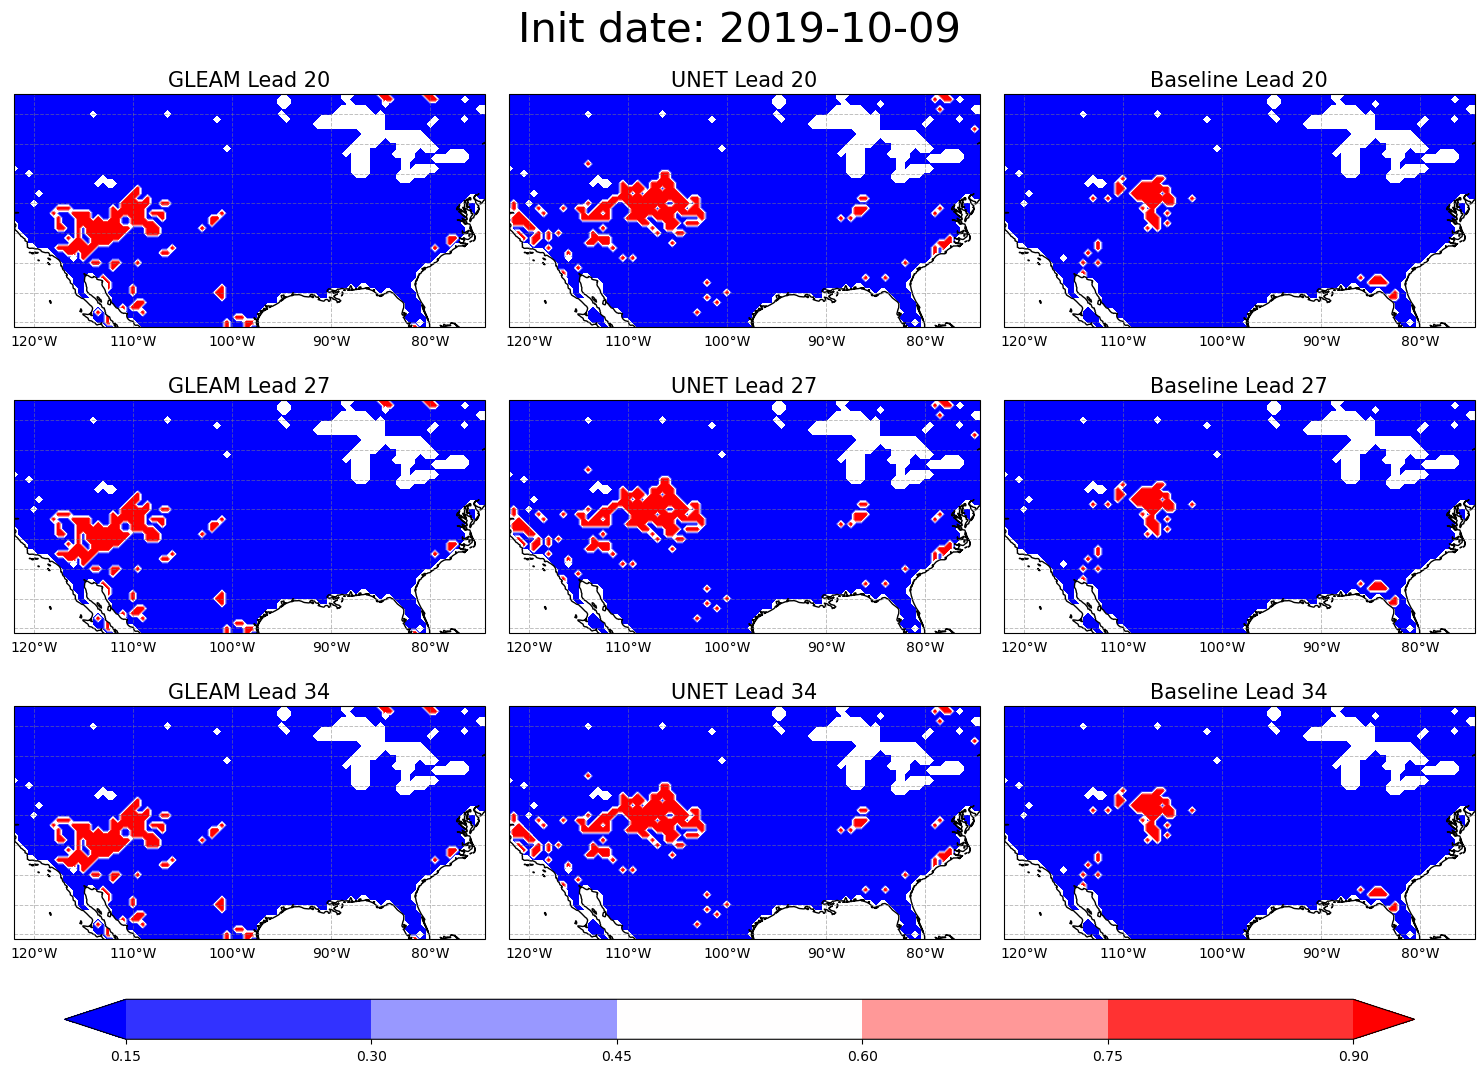

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

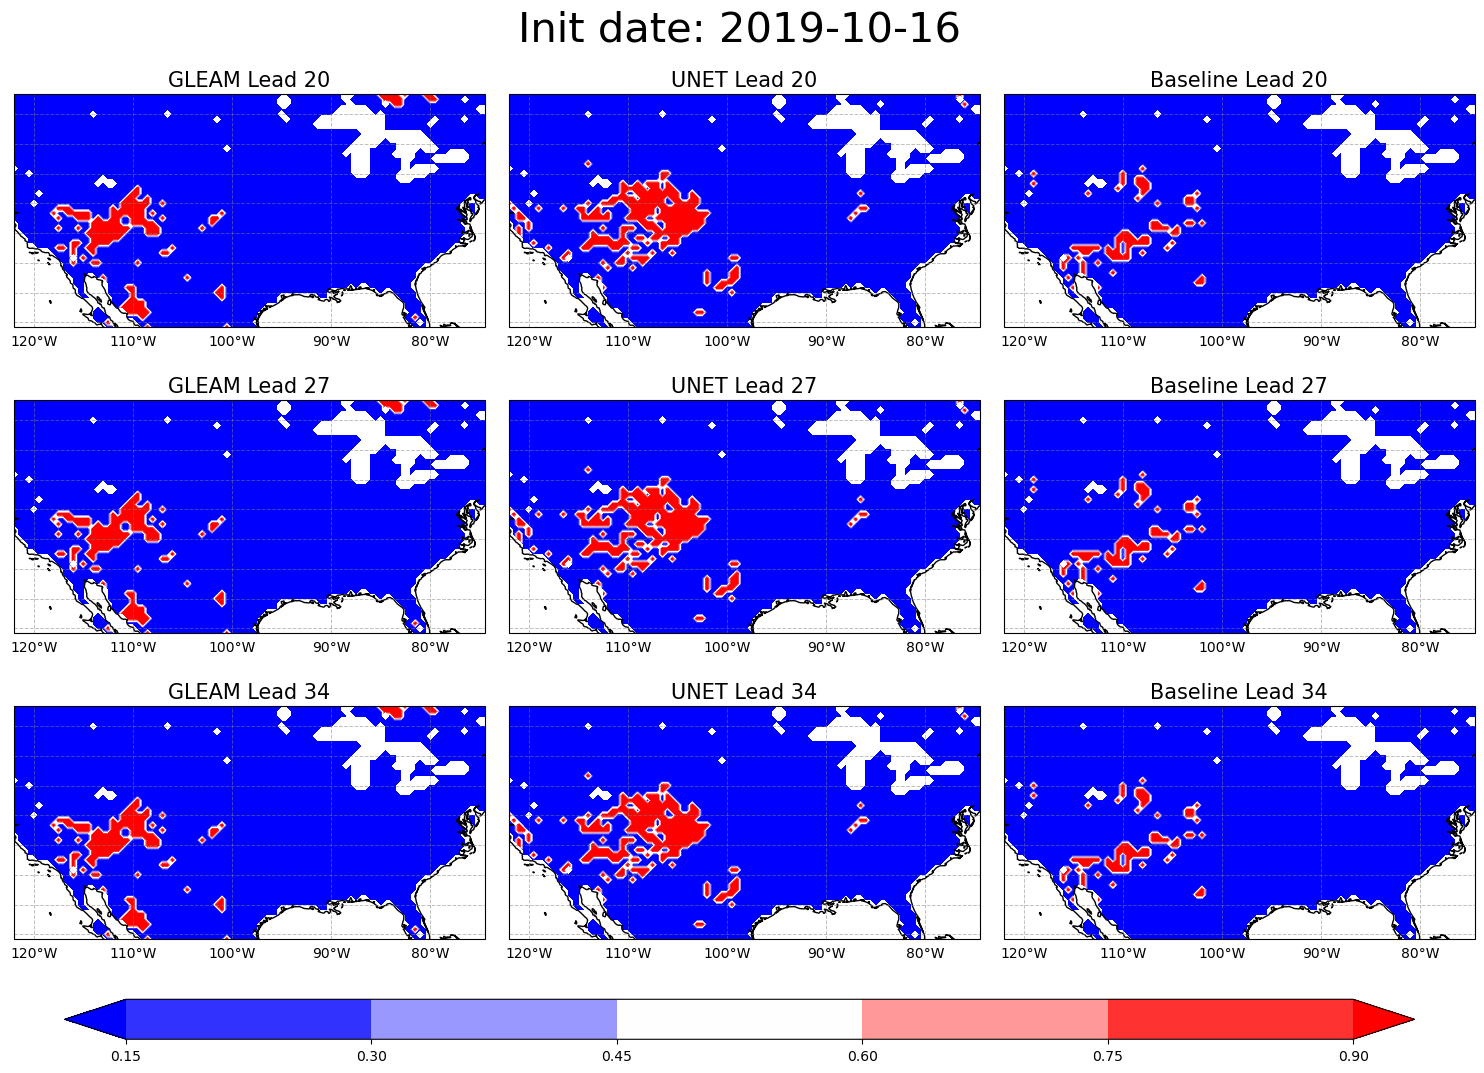

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

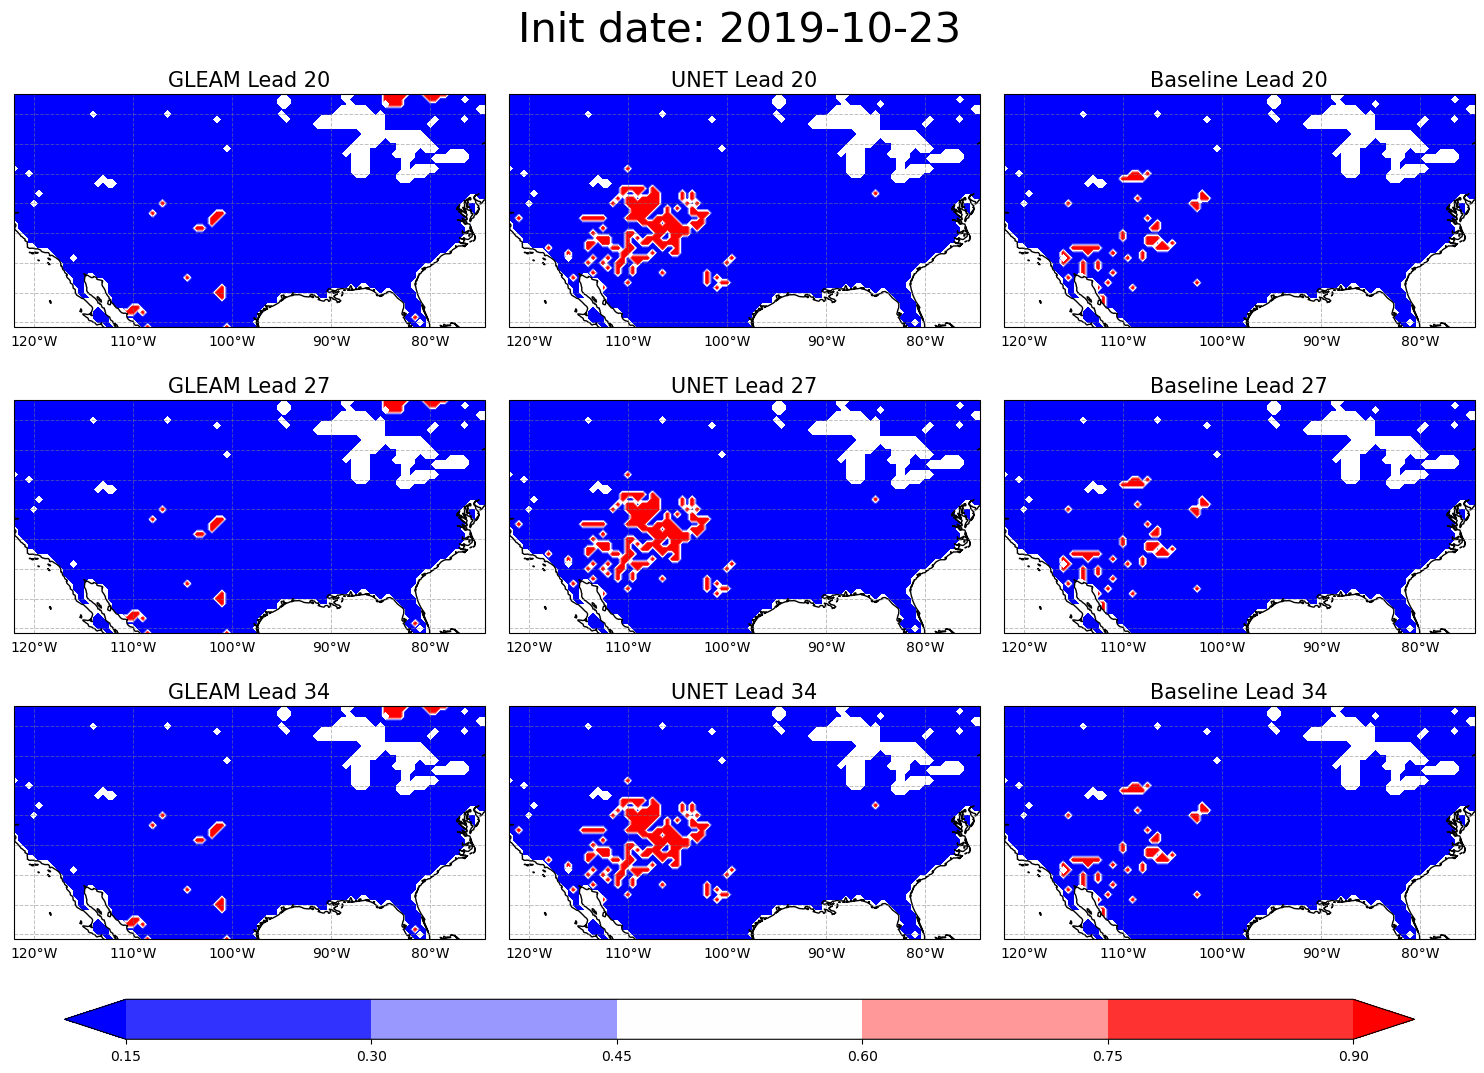

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Plea

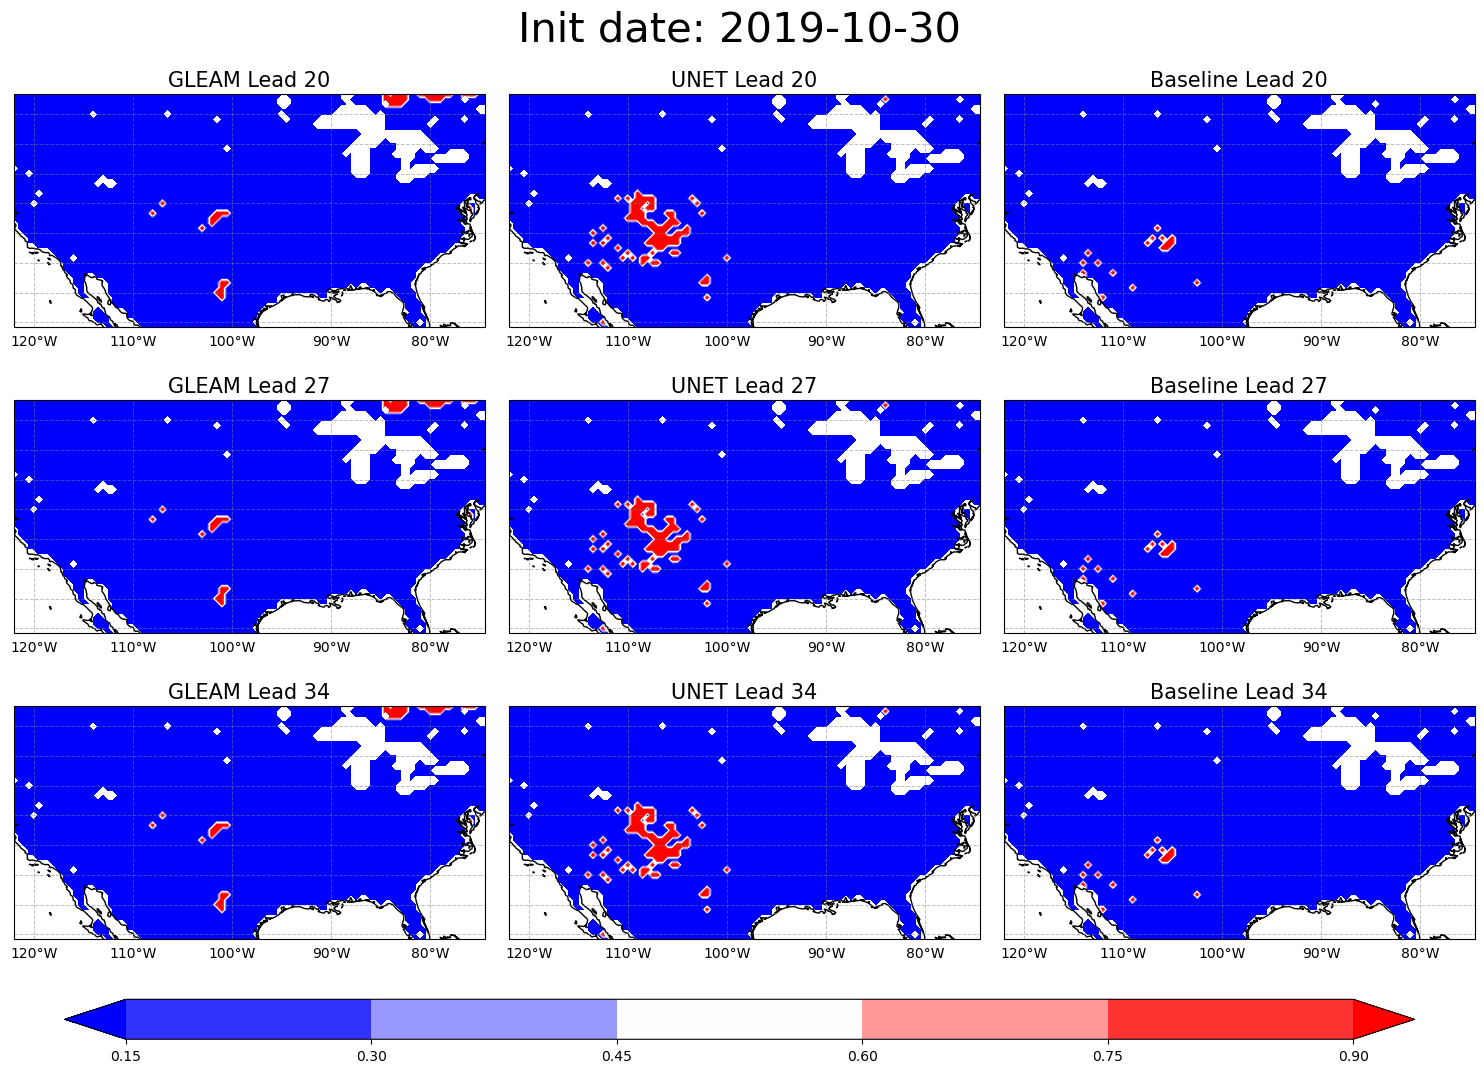

In [36]:
for init_date in obs_anom.S.values:
    plot_case_study_rci(obs=obs_anom, unet=unet_anom, baseline=baseline_anom, init_date=init_date)

# Plot percentages of SMVI across CONUS (incomplete)

In [ ]:
def load_metric_file(metric, probability_or_MEM):
    if probability_or_MEM == 0.5:
        baseline = xr.open_dataset(f'Data/GEFSv12_reforecast/soilw_bgrnd/SMVI/metric_values/{metric}_percentage_probability{probability_or_MEM}.nc').sel(L=[20,27,34])
        unet = xr.open_dataset(f'predictions/UNET/SMVI/{experiment_name}/metric_values/{metric}_percentage_probability{probability_or_MEM}.nc').sel(L=[20,27,34])
    elif probability_or_MEM == 'MEM':
        baseline = xr.open_dataset(f'Data/GEFSv12_reforecast/soilw_bgrnd/SMVI/metric_values/{metric}_percentage_MEM.nc').sel(L=[20,27,34])
        unet = xr.open_dataset(f'predictions/UNET/SMVI/{experiment_name}/metric_values/{metric}_percentage_MEM.nc').sel(L=[20,27,34])
    return(baseline, unet)

In [ ]:


# cmap = 'coolwarm'
def plot_metric(metric,probability_or_MEM):

    
    cmap = plt.get_cmap('bwr')    
    
    save_dir = f'Outputs/FD_metrics'
    os.system(f'mkdir -p {save_dir}')
        
    fig, axs = plt.subplots(
        nrows = 1, ncols= 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 10))
    axs = axs.flatten()
    
    
    min_,max_ = get_min_max_of_files_anomaly(obs, unet, baseline, date)
    # test_file = mae_rzsm_keys
    # for Subx original data
    
    lon = obs.X.values
    lat = obs.Y.values
    
    axs_start = 0
    for lead in [20,27,34]:
        for data_to_plot,name in zip([obs, unet, baseline], ['GLEAM','UNET','Baseline']):
            # break
            data = return_array_anomaly(file=data_to_plot,lead=lead, date=date)
    
            v = np.linspace(min_, max_, 20, endpoint=True)
        
            map = Basemap(projection='cyl', llcrnrlat=25, urcrnrlat=50,
                          llcrnrlon=-128, urcrnrlon=-60, resolution='l')
            x, y = map(*np.meshgrid(lon, lat))
            # Adjust the text coordinates based on the actual data coordinates
        
            norm = TwoSlopeNorm(vmin=min_, vcenter=0, vmax=max_)
        
            im = axs[axs_start].contourf(x, y, data, levels=v, extend='both',
                                  transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)
    
    
            # axs[idx].title.set_text(f'SubX Lead {lead*7}')
            gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                       linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
            gl.xlabels_top = False
            gl.ylabels_right = False
            if lead != 1:
                gl.ylabels_left = False
            gl.xformatter = LongitudeFormatter()
            gl.yformatter = LatitudeFormatter()
            axs[axs_start].coastlines()
            # plt.colorbar(im)
            # axs[idx].set_aspect('auto', adjustable=None)
            axs[axs_start].set_aspect('equal')  # this makes the plots better
            axs[axs_start].set_title(f'{name} Lead {lead}',fontsize=15)

            if name in ['UNET','Baseline']:
                # Calculate the Pearson correlation coefficient
                obs_corr = return_array_anomaly(file=obs,lead=lead, date=date).flatten()
                data_corr = data.flatten()

                data_corr = data_corr[~np.isnan(obs_corr)]
                obs_corr = obs_corr[~np.isnan(obs_corr)]
                
                correlation_matrix = np.corrcoef(obs_corr, data_corr)
                # The correlation coefficient is in the top right corner of the correlation matrix
                correlation_coefficient = correlation_matrix[0, 1]
                correlation_coefficient = round(correlation_coefficient,4)
                #find the correlation coefficient across the dataset
                axs[axs_start].text(text_x, text_y, f'Corr: {correlation_coefficient}', ha='right', va='bottom', fontsize=font_size_corr, color='blue', weight = 'bold')
            
            
            axs_start+=1
            
    cbar_ax = fig.add_axes([0.05, -0.05, .9, .04])
    
    # Draw the colorbar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    fig.suptitle(f'Init date: {date}', fontsize=30)
    fig.tight_layout()
    
    plt.savefig(f'{save_dir}/{metric}.png',bbox_inches='tight')
    plt.show()
